# Build an even lighter model
##Target
* Remove the last layer with Global Average Pooling layer

## Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Add Data Transformer, Data Loaders and training and testing data

In [ ]:
#Data Transformations

# Train Phase transformations
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])
# Load Train and Test Data
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Configure Test/Train Dataloaders
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


## Model Defination

In [ ]:
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.1)
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(0.1)
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        )

        self.pool1 = nn.MaxPool2d(2, 2)
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.1)
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        )

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        )



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model3().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]             864
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,728
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1,

# Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Start Training and Testing

In [ ]:
model =  Model3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1531604826450348 Batch_id=937 Accuracy=86.33: 100%|██████████| 938/938 [01:18<00:00, 11.93it/s]



Test set: Average loss: 0.1078, Accuracy: 9686/10000 (96.8600%)

EPOCH: 1


Loss=0.04974820464849472 Batch_id=937 Accuracy=96.26: 100%|██████████| 938/938 [01:10<00:00, 13.27it/s]



Test set: Average loss: 0.0755, Accuracy: 9779/10000 (97.7900%)

EPOCH: 2


Loss=0.08762232959270477 Batch_id=937 Accuracy=96.96: 100%|██████████| 938/938 [01:10<00:00, 13.39it/s]



Test set: Average loss: 0.0636, Accuracy: 9797/10000 (97.9700%)

EPOCH: 3


Loss=0.11097446829080582 Batch_id=937 Accuracy=97.29: 100%|██████████| 938/938 [01:10<00:00, 13.31it/s]



Test set: Average loss: 0.0574, Accuracy: 9832/10000 (98.3200%)

EPOCH: 4


Loss=0.016568530350923538 Batch_id=937 Accuracy=97.49: 100%|██████████| 938/938 [01:09<00:00, 13.51it/s]



Test set: Average loss: 0.0542, Accuracy: 9835/10000 (98.3500%)

EPOCH: 5


Loss=0.3004997968673706 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [01:10<00:00, 13.36it/s]



Test set: Average loss: 0.0485, Accuracy: 9859/10000 (98.5900%)

EPOCH: 6


Loss=0.08048364520072937 Batch_id=937 Accuracy=97.76: 100%|██████████| 938/938 [01:09<00:00, 13.53it/s]



Test set: Average loss: 0.0426, Accuracy: 9871/10000 (98.7100%)

EPOCH: 7


Loss=0.056695520877838135 Batch_id=937 Accuracy=97.93: 100%|██████████| 938/938 [01:09<00:00, 13.46it/s]



Test set: Average loss: 0.0434, Accuracy: 9866/10000 (98.6600%)

EPOCH: 8


Loss=0.020975681021809578 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [01:08<00:00, 13.64it/s]



Test set: Average loss: 0.0464, Accuracy: 9856/10000 (98.5600%)

EPOCH: 9


Loss=0.01680760830640793 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [01:09<00:00, 13.43it/s]



Test set: Average loss: 0.0413, Accuracy: 9881/10000 (98.8100%)

EPOCH: 10


Loss=0.11901653558015823 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [01:10<00:00, 13.38it/s]



Test set: Average loss: 0.0456, Accuracy: 9859/10000 (98.5900%)

EPOCH: 11


Loss=0.3206159174442291 Batch_id=937 Accuracy=98.15: 100%|██████████| 938/938 [01:08<00:00, 13.60it/s]



Test set: Average loss: 0.0365, Accuracy: 9890/10000 (98.9000%)

EPOCH: 12


Loss=0.0034081367775797844 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [01:10<00:00, 13.38it/s]



Test set: Average loss: 0.0409, Accuracy: 9872/10000 (98.7200%)

EPOCH: 13


Loss=0.14822684228420258 Batch_id=937 Accuracy=98.23: 100%|██████████| 938/938 [01:12<00:00, 13.00it/s]



Test set: Average loss: 0.0368, Accuracy: 9886/10000 (98.8600%)

EPOCH: 14


Loss=0.02023310959339142 Batch_id=937 Accuracy=98.27: 100%|██████████| 938/938 [01:10<00:00, 13.26it/s]



Test set: Average loss: 0.0392, Accuracy: 9879/10000 (98.7900%)



##Plot the graphs to analyze the model

Text(0.5, 1.0, 'Test Accuracy')

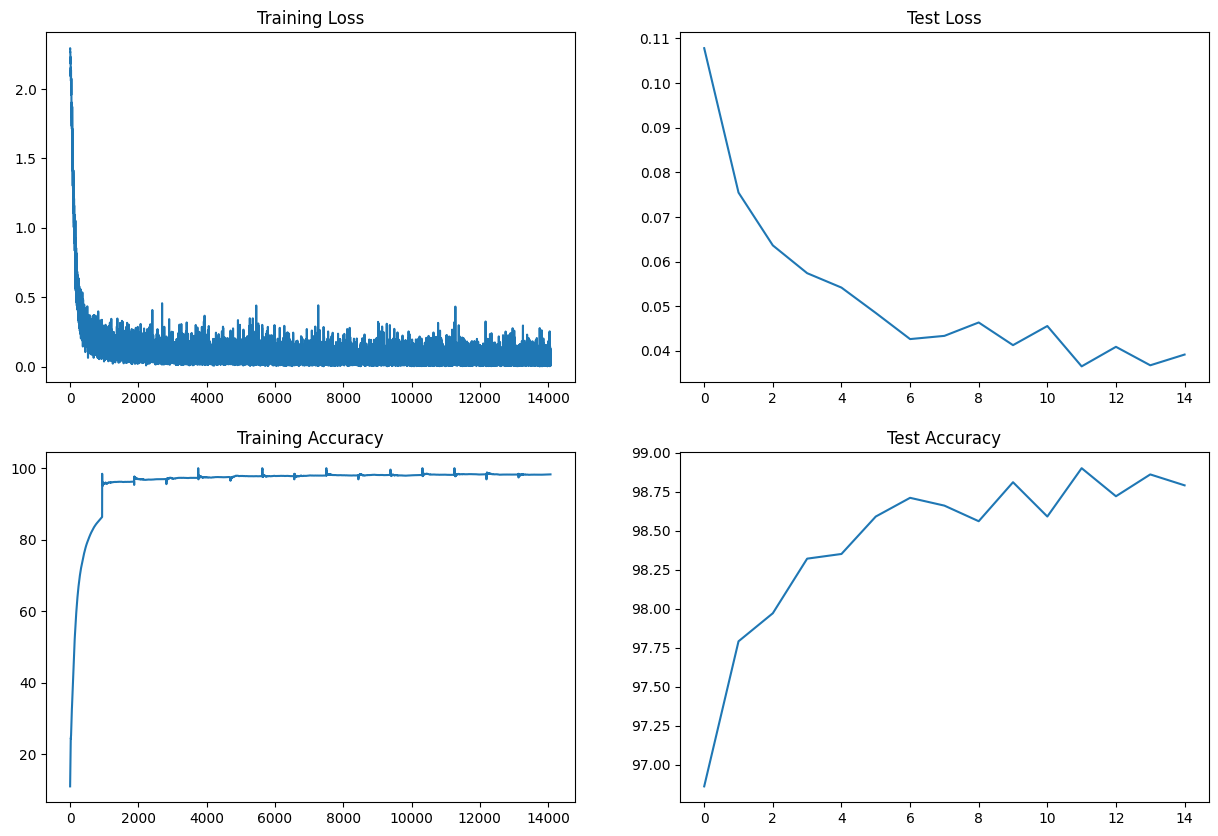

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Result
* **Total number of parameters**: 5.5 k
* **Best Training Accuracy**: 98.27%
* **Best Test Accuracy**:98.79%

# Analysis
* The models **training accuracy has been stagnated** at around 98.15 - 98.27%. As this is not increasing, we understand that we need to increase the complexity of the model.
* Test accuracy is little higher than training accuracy, which means the model is **not overfitting**.